IMPORTING REQUIRED LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import math
import time
import seaborn as sns   
import xgboost as xgb
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.utils.class_weight import compute_sample_weight

In [2]:
tqdm.pandas()

READING THE DATA

In [3]:
train = pd.read_csv('data_set/train.csv')
test = pd.read_csv('data_set/test.csv')
sample_submission = pd.read_csv('data_set/sample_submission.csv')

* order_id : unique id for each order
* order_time: time of the creation of order by the client
* order_date : date of the order
* allot_time: time of allocation of order to the rider
* accept_time: time of acceptance of the order by the rider (if available)
* pickup_time: time of pickup of the order (if available)
* delivered_time: time of delivery of the order (if available)
* cancelled_time: time of cancellation of order (if the order was cancelled)
* cancelled: whether the order was cancelled
* rider_id: unique id for each rider
* first_mile_distance: road distance from rider’s location to the pickup location
* last_mile_distance: road distance from pickup location to the delivery location
* allotted_orders: total number of orders allotted to the rider in the 30 days before (not including) order_date
* delivered_orders: total number of orders delivered by the rider in the 30 days before (not including) order_date
* undelivered_orders: total number of orders allotted to but not delivered by the rider (i.e. cancelled) in the 30 days before (not including) order_date
* lifetime_order_count: total number of orders delivered by the rider at any time before order_date
* reassigned_order: whether the order was reassigned to this rider
* reassignment_method: if the order was reassigned, whether the reassignment was done manually (by the ops team) or automatically
* reassignment_reason: a more detailed reason for the reassignment
* session_time: total time the rider had been online on order_date before order_time

MAKING THE FEATURES CATEGORIES

In [4]:
id_columns = ['order_id']

time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']

categorical_columns = ['reassignment_method','reassignment_reason']

CONVERTING TO DATETIME AND OBJECT


In [5]:
ids = train[id_columns]
train = train.drop(ids, axis=1)
test = test.drop(ids,axis=1)

for col in time_columns:
    train[col] = pd.to_datetime(train[col])
    try:
        test[col] = pd.to_datetime(test[col])
    except:
        continue

for col in categorical_columns:
    train[col] = train[col].astype('object')
    try:
        test[col] = test[col].astype('object')
    except:
        continue


C:\Users\Nikhil\AppData\Local\Temp\ipykernel_5136\3519238318.py:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train[col] = pd.to_datetime(train[col])
C:\Users\Nikhil\AppData\Local\Temp\ipykernel_5136\3519238318.py:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train[col] = pd.to_datetime(train[col])
C:\Users\Nikhil\AppData\Local\Temp\ipykernel_5136\3519238318.py:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train[col] = pd.to_datetime(train[col])
C:\Users\Nikhil\AppData\Local\Temp\ipykernel_5136\3519238318.py:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass

PREPROCESSING

In [6]:
def peak_hour(x):
    if (x >= 8 and x <= 11) or (x >= 13 and x <= 19):
        return 1
    return 0

def log_normal(x):
    if x == 0:
        return 0
    return math.log(x) if x > 0 else math.log(abs(x))


In [7]:
def preprocess(df):
    df['order_day'] = df['order_date'].dt.dayofyear
    df['diff_allot_order'] = (df['allot_time'] - df['order_time']).dt.total_seconds()
    df['diff_accept_allot'] = (df['accept_time'] - df['allot_time']).dt.total_seconds()
    df['diff_accept_order'] = (df['accept_time'] - df['order_time']).dt.total_seconds()
    df['total_dist'] = df['first_mile_distance']+df['last_mile_distance']
    df['hour_in_day'] = df['order_time'].dt.hour
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df[['cum_diff_allot_order','cum_diff_accept_allot','cum_diff_accept_order','cum_total_dist','cum_first_mile_dist','cum_last_mile_dist']]=df.groupby(['rider_id','order_date'])[['diff_allot_order','diff_accept_allot','diff_accept_order','total_dist','first_mile_distance','last_mile_distance']].cumsum()
    df['order_today'] = df.groupby(['rider_id','order_date']).cumcount()
    df['orders_cum'] = df.groupby(['rider_id']).cumcount()
    df['reassigned_order'] = df['reassigned_order'].fillna(0)                                                      
    df['saturday'] = df['day_of_week'].apply(lambda x:1 if x==5 else 0)
    for col in df.columns:
        if df[col].isnull().sum()>0:
            df[col]=df[col].fillna(0)
    df['orders_diff'] = df['alloted_orders']-df['delivered_orders']
    riders = df.groupby(['order_date','hour_in_day'])['rider_id'].count().to_dict()
    df['riders_available'] = df.apply(lambda x: riders[(x.order_date,x.hour_in_day)],axis=1)
    df['reliability'] = (df['alloted_orders']-df['undelivered_orders'])*100/df['alloted_orders']
    df['reliability'] = df['reliability'].fillna(0)
    cols = []
    col_dict = ((df.dtypes==int)|(df.dtypes==float)).to_dict()
    for col in col_dict.keys():
        if col_dict[col]:
            cols.append(col)
    df["mean"] = df[cols].mean(axis=1)
    df["std"] = df[cols].std(axis=1)
    df["min"] = df[cols].min(axis=1)
    df["max"] = df[cols].max(axis=1) 
    
    return df


TRAIN AND VALID SPLITTING

In [8]:

train = preprocess(train)
test = preprocess(test)

In [9]:

X = train.drop("cancelled", axis=1)
y = train["cancelled"]

X = X.select_dtypes(include=['int64','float64'])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)



RIDER DATA FEATURE ENGINEERING


In [10]:

rider_cols_mean = [
    'session_time',
    'first_mile_distance',
    'last_mile_distance',
    'total_dist'
]

rider_train_data = X_train.copy()

rider_cumsum = rider_train_data.groupby('rider_id')[rider_cols_mean].cumsum()
rider_cumsum['rider_order_count'] = rider_train_data.groupby('rider_id').cumcount() + 1

for col in rider_cols_mean:
    rider_cumsum[col] = rider_cumsum[col] / rider_cumsum['rider_order_count']

rider_cumsum = rider_cumsum.rename(columns={
    'session_time': 'rider_avg_session_time',
    'first_mile_distance': 'rider_avg_first_mile',
    'last_mile_distance': 'rider_avg_last_mile',
    'total_dist': 'rider_avg_total_dist'
})

rider_means = rider_cumsum.groupby(X_train['rider_id']).last()


In [11]:

X_train = X_train.merge(
    rider_cumsum,
    left_index=True,
    right_index=True,
    how='left'
)


X_valid = X_valid.merge(
    rider_means,
    left_on='rider_id',
    right_index=True,
    how='left'
)

test = test.merge(
    rider_means,
    left_on='rider_id',
    right_index=True,
    how='left'
)



In [12]:

time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']
numerical_columns = ['first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'lifetime_order_count',
                    'session_time','diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist','cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order', 'cum_total_dist', 'allotted_orders',
                     'riders_available','orders_cum','reliability']
categorical_columns = ['reassignment_method','reassignment_reason','reassigned_order','order_day','hour_in_day','undelivered_orders','day_of_week',
                       'order_today', 'allotted', 'deliveries','period_in_day','saturday','first_mile', 'last_mile','orders_diff']




In [13]:
X_train = X_train.select_dtypes(include=['int64','float64'])
X_valid = X_valid.select_dtypes(include=['int64','float64'])

feature_columns = X_train.columns



In [14]:

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=feature_columns,
    index=X_train.index
)

X_valid = pd.DataFrame(
    imputer.transform(X_valid),
    columns=feature_columns,
    index=X_valid.index
)

test_imputed = pd.DataFrame(
    imputer.transform(test[feature_columns]),
    columns=feature_columns,
    index=test.index
)
test_data = test_imputed.copy()

In [15]:

print(X_train.columns)
# the below features must not cause redundancy in the data, so we should focus on the below features for training the model


Index(['rider_id', 'first_mile_distance', 'last_mile_distance',
       'alloted_orders', 'delivered_orders', 'undelivered_orders',
       'lifetime_order_count', 'reassigned_order', 'session_time',
       'diff_allot_order', 'diff_accept_allot', 'diff_accept_order',
       'total_dist', 'cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order', 'cum_total_dist', 'cum_first_mile_dist',
       'cum_last_mile_dist', 'order_today', 'orders_cum', 'saturday',
       'orders_diff', 'riders_available', 'reliability', 'mean', 'std', 'min',
       'max', 'rider_avg_session_time', 'rider_avg_first_mile',
       'rider_avg_last_mile', 'rider_avg_total_dist', 'rider_order_count'],
      dtype='object')




CLASSIFICATION MODELS PREDICTIONS

* All model hyperparameters were tuned using RandomizedSearchCV or GridSearch



In [16]:

print(X_train.dtypes)
# descision tree based models convert the data into floats internally, so we should discard timestamps for it the below data types must be float or int only.



rider_id                  float64
first_mile_distance       float64
last_mile_distance        float64
alloted_orders            float64
delivered_orders          float64
undelivered_orders        float64
lifetime_order_count      float64
reassigned_order          float64
session_time              float64
diff_allot_order          float64
diff_accept_allot         float64
diff_accept_order         float64
total_dist                float64
cum_diff_allot_order      float64
cum_diff_accept_allot     float64
cum_diff_accept_order     float64
cum_total_dist            float64
cum_first_mile_dist       float64
cum_last_mile_dist        float64
order_today               float64
orders_cum                float64
saturday                  float64
orders_diff               float64
riders_available          float64
reliability               float64
mean                      float64
std                       float64
min                       float64
max                       float64
rider_avg_sess

RANDOM FOREST CLASSIFIER


In [17]:

rf_param_dist = {
    'n_estimators': randint(100, 300),          
    'max_depth': randint(10, 20),               
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'class_weight': ['balanced']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=2020),
    param_distributions=rf_param_dist,
    n_iter=8,                 
    scoring='roc_auc',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

rf = rf_random.best_estimator_



Fitting 3 folds for each of 8 candidates, totalling 24 fits


              precision    recall  f1-score   support

           0       0.99      0.98      0.99     88956
           1       0.15      0.27      0.19      1044

    accuracy                           0.97     90000
   macro avg       0.57      0.63      0.59     90000
weighted avg       0.98      0.97      0.98     90000

Test Accuracy:  0.9734
Train Accuracy:  0.9689166666666666
AUC Score: 0.7305300338761477


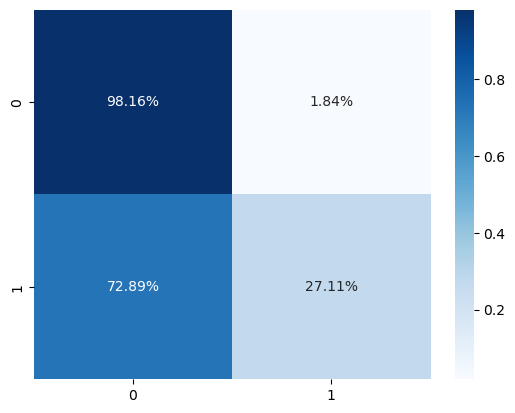

In [18]:

rf_preds = rf.predict(X_valid)
rf_preds_prob = rf.predict_proba(X_valid)[:,1]

result = confusion_matrix(y_valid, rf_preds)
r = np.sum(result, axis=1)
a,b,c,d = result[0][0]/r[0], result[0][1]/r[0], result[1][0]/r[1], result[1][1]/r[1]

sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_valid, rf_preds))
print('Test Accuracy: ', rf.score(X_valid,y_valid))
print('Train Accuracy: ', rf.score(X_train,y_train))
print('AUC Score:', roc_auc_score(y_valid, rf_preds_prob))
